# **DATA INITIZLIZATION**

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import gc

import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import math
import lightgbm as lgb
from tqdm.notebook import tqdm
tqdm.pandas()

#!pip install Wordbatch
#from wordbatch.models import FTRL, FM_FTRL  # https://github.com/anttttti/Wordbatch
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from sklearn.model_selection import train_test_split
import scipy
from scipy.sparse import hstack

from sklearn.metrics import mean_squared_log_error
import pickle
import regex as re
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/My Drive/Colab Notebooks/'

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# if 'train.tsv' not in os.listdir(): 
#     !kaggle competitions download -c mercari-price-suggestion-challenge
#     get_ipython().system_raw("7z x \*.7z && rm *.7z")
#     get_ipython().system_raw("7z x \*.zip && rm *.zip")

In [3]:
import pandas as pd

train_df = pd.read_pickle('../input/mercari-ml-data-processed/improved_train.pkl')
test_df = pd.read_pickle('../input/mercari-ml-data-processed/improved_test.pkl')

# train_df.head(5)

In [4]:
# train_df = train_df.head(50)
# test_df = test_df.head(50)

**Train Test Split**

In [5]:
X = train_df.drop(['train_id','log_prices','price'], axis=1)
y = train_df['log_prices']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
del X, y, train_df

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1237027, 15)
(1237027,)
(65107, 15)
(65107,)


### **Feature Engineering pipeline**

# **CNN MODEL**

In [7]:
from sklearn.preprocessing import Normalizer
import tensorflow as tf
from numpy import array
from numpy import asarray
from numpy import zeros
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Embedding, Conv1D, Conv2D, MaxPool1D, MaxPool2D, AveragePooling1D, GlobalAveragePooling1D, \
                                    Flatten, Dropout, Dense, BatchNormalization, LayerNormalization, Concatenate
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM

In [8]:
# THIS CODE IS USED TO OVERCOME THE UNKNOWN CATEGORICAL VALUES ENCOUNTERED IN THE TEST DATA, WHEN USING Sklearn's LabelEncoder
# We basically add a 'Unknown' category when fitting, to accomodate all the unseen/unknown values in test data
# https://stackoverflow.com/a/56876351/7697658

from sklearn.preprocessing import LabelEncoder
import numpy as np

class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [9]:
# Why you should not use One Hot Encoding for this,
# https://stackoverflow.com/a/51184399/7697658

# Embedding categorical data,
# https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/
def categorical_embeddings(cat_train, cat_test):
    """
    This function will do Label encoding of the categorical feature.
    """
    vocab_size = len(cat_train.unique())+1
    le = LabelEncoderExt()
    le.fit(cat_train.values)
    encoded_train = le.transform(cat_train.values)
    encoded_test = le.transform(cat_test.values)

    return vocab_size, encoded_train, encoded_test

#vocab_size, encoded_train, encoded_test = categorical_embeddings(X_train['project_subject_subcategories'], X_test['project_subject_subcategories'])

In [10]:
# How does embedding layer work,
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work

def text_embeddings(text_train, text_test):
    """
    This function does the tokenizing, padding, creating vocab and creating the embedding matrix for text data
    """
    # Word Tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text_train)
    encoded_docs_train = tokenizer.texts_to_sequences(text_train)

    encoded_docs_test = tokenizer.texts_to_sequences(text_test)

    # Getting the 'max len' of doc among the text_train
    len_docs = []
    for doc in text_train:
        splitted_doc = doc.split()
        len_docs.append(len(splitted_doc))
    max_len_doc = max(len_docs)
    #print('max doc len=',max_len_doc) # in terms of words

    text_train_padded = pad_sequences(encoded_docs_train, maxlen=max_len_doc, padding='post')
    text_test_padded = pad_sequences(encoded_docs_test, maxlen=max_len_doc, padding='post')

    vocab_size = len(tokenizer.word_index) + 1
    #print(vocab_size)

    embeddings_index = dict()
    with open('../input/glove6b/glove.6B.200d.txt') as f:
        for line in f:
            w_coef = line.rstrip().rsplit(' ')
            word = w_coef[0]
            coefs = asarray(w_coef[1:], dtype='float32')
            embeddings_index[word]=coefs

    embedding_matrix = zeros((vocab_size, 200))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix, vocab_size, max_len_doc, text_train_padded, text_test_padded

In [11]:
def text_model_pipeline(input_len, vocab_size, embedding_matrix, layer_name):
    """
    This function will create a sub-model of the text data using embedding layer, 1D CNN, Maxpooling.
    """
    input_layer = Input(shape=input_len, name=layer_name+'_input')
    e_layer = Embedding(input_dim=vocab_size, output_dim=200, weights=[embedding_matrix], input_length=input_len, trainable=False, name=layer_name+'_embedding')(input_layer)
    conv_1 = Conv1D(filters=128, kernel_size=3, strides=1, padding='same', kernel_initializer=initializers.glorot_normal(seed=0), 
                activation='relu', kernel_regularizer=regularizers.l2(),name=layer_name+'Conv_1')(e_layer)
    conv_1 = MaxPool1D(pool_size=20, strides=1, padding='same', name=layer_name+'Maxpool_1')(conv_1)
    conv_1 = Flatten()(conv_1)

    out = conv_1
    model = Model(inputs=input_layer ,outputs=out)
    return model

def categorical_model_pipeline(input_len, vocab_size, layer_name):   # Here vocab_size will be the number of unique values in the column
    """
    This function will create a sub-model of the categorical data. It will use embedding layer to embedd the categories.
    """
    input_layer = Input(shape=input_len, name=layer_name+'_input')
    e_layer  = Embedding(input_dim=vocab_size, output_dim=32, input_length=input_len, trainable=True, name=layer_name+'_embedding')(input_layer)
    flat = Flatten()(e_layer)
    out = flat
    model = Model(inputs=input_layer ,outputs=out)
    return model

def numeric_model_pipeline(input_len, layer_name):
    """
    This function will create a sub-model of the numeric data using a single dense layer.
    """
    input_layer = Input(shape=input_len, name=layer_name+'_input')
    dense = Dense(units=32,activation='relu', name=layer_name+'_dense')(input_layer)
    out = dense
    model = Model(inputs=input_layer ,outputs=out)
    return model

def low_cardinal_categories(input_len, layer_name):
    """
    This function will create a sub-model of the low cardinal features. This just flattens the input and nothing else.
    """
    input_layer = Input(shape=input_len, name=layer_name+'_input')
    flat = Flatten()(input_layer)
    out = flat
    model = Model(inputs=input_layer ,outputs=out)
    return model

In [12]:
def numeric_standardizing(X_train_numeric, X_test_numeric):
    """
    This function will normalize the numeric feature.
    """
    scaler = Normalizer()
    scaler.fit(X_train_numeric.values.reshape(1,-1))

    X_train_price_scaled = scaler.transform(X_train_numeric.values.reshape(1,-1))
    X_test_price_scaled = scaler.transform(X_test_numeric.values.reshape(1,-1))
    return X_train_price_scaled.flatten(), X_test_price_scaled.flatten()

In [13]:
tf.keras.backend.clear_session()

def create_cnn_model(X_train, X_test):
    """
    This function creates the model structure.
    """
    ####################### Text data ######################
    desc_embedding_matrix, desc_vocab_size, desc_max_len_doc, desc_text_train_padded, desc_text_test_padded = text_embeddings(X_train['item_description'].apply(str), X_test['item_description'].apply(str))
    name_embedding_matrix, name_vocab_size, name_max_len_doc, name_text_train_padded, name_text_test_padded = text_embeddings(X_train['name'].apply(str), X_test['name'].apply(str))

    desc_flat_model = text_model_pipeline(desc_max_len_doc, desc_vocab_size, desc_embedding_matrix, 'description')
    name_flat_model = text_model_pipeline(name_max_len_doc, name_vocab_size, name_embedding_matrix, 'name')
    ########################################################


    ################### Categorical data ###################
    bn_vocab_size, bn_encoded_train, bn_encoded_test = categorical_embeddings(X_train['brand_name'], X_test['brand_name'])
    gc_vocab_size, gc_encoded_train, gc_encoded_test = categorical_embeddings(X_train['general_cat'], X_test['general_cat'])
    sc1_vocab_size, sc1_encoded_train, sc1_encoded_test = categorical_embeddings(X_train['subcat_1'], X_test['subcat_1'])
    sc2_vocab_size, sc2_encoded_train, sc2_encoded_test = categorical_embeddings(X_train['subcat_2'], X_test['subcat_2'])

    bn_flat_model = categorical_model_pipeline(1, bn_vocab_size, 'bn')
    gc_flat_model = categorical_model_pipeline(1, gc_vocab_size, 'gc')
    sc1_flat_model = categorical_model_pipeline(1, sc1_vocab_size, 'sc1')
    sc2_flat_model = categorical_model_pipeline(1, sc2_vocab_size, 'sc2')
    ic_flat_model = low_cardinal_categories(5, 'item_condition')
    sh_flat_model = low_cardinal_categories(2, 'shipping')
    is_ex_flat_model = low_cardinal_categories(2, 'isExpensive')
    #########################################################


    ################### Numeric data ###################
    numeric_train_input = pd.concat((X_train['scaler_desc_len'], X_train['scaler_name_len']), axis=1).to_numpy()
    numeric_test_input = pd.concat((X_test['scaler_desc_len'], X_test['scaler_name_len']), axis=1).to_numpy()

    numeric_model = numeric_model_pipeline(numeric_train_input.shape[1], 'numeric')
    ####################################################


    ############### Concatenating layers ###############
    combined_layers = [desc_flat_model.output, name_flat_model.output, 
                       bn_flat_model.output, gc_flat_model.output, sc1_flat_model.output, sc2_flat_model.output, ic_flat_model.output, \
                       sh_flat_model.output, is_ex_flat_model.output, numeric_model.output]
    concatenate_layer = Concatenate()(combined_layers)
    ####################################################

    dense = BatchNormalization()(concatenate_layer)
    dense = Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dense)
    dense = Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dense)
    concatenate_layer = Concatenate()([dense, ic_flat_model.output, sh_flat_model.output, is_ex_flat_model.output, numeric_model.output])
    dense = LayerNormalization(axis=1)(concatenate_layer)
    #dense = Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(concatenate_layer)

    out = Dense(units=1, activation='linear', name='Output')(dense)

    model = Model(inputs=[desc_flat_model.input, name_flat_model.input, 
                       bn_flat_model.input, gc_flat_model.input, sc1_flat_model.input, sc2_flat_model.input, ic_flat_model.input, \
                       sh_flat_model.input, is_ex_flat_model.input, numeric_model.input], \
                  outputs=out)


    X_train_inputs = [desc_text_train_padded, name_text_train_padded, bn_encoded_train, gc_encoded_train, sc1_encoded_train, sc2_encoded_train, tf.one_hot(X_train['item_condition_id'], 5),\
                      tf.one_hot(X_train['shipping'], 2), tf.one_hot(X_train['is_expensive'], 2), numeric_train_input]
    X_test_inputs = [desc_text_test_padded, name_text_test_padded, bn_encoded_test, gc_encoded_test, sc1_encoded_test, sc2_encoded_test, tf.one_hot(X_test['item_condition_id'], 5),\
                     tf.one_hot(X_test['shipping'], 2), tf.one_hot(X_test['is_expensive'], 2), numeric_test_input]
    return model, X_train_inputs, X_test_inputs

In [14]:
# X_train, scaler_name_len, scaler_desc_len = feature_pipeline(X_train, scaler_name_len=None, scaler_desc_len=None)
# X_test, _, _ = feature_pipeline(X_test, scaler_name_len, scaler_desc_len)
scaler_name_len = X_train['scaler_name_len']
scaler_desc_len = X_train['scaler_desc_len']

print(scaler_name_len.shape, scaler_desc_len.shape)

(1237027,) (1237027,)


In [15]:
cnn_model, X_train_inputs, X_test_inputs = create_cnn_model(X_train, X_test)
cnn_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
description_input (InputLayer)  [(None, 251)]        0                                            
__________________________________________________________________________________________________
name_input (InputLayer)         [(None, 12)]         0                                            
__________________________________________________________________________________________________
description_embedding (Embeddin (None, 251, 200)     29178000    description_input[0][0]          
__________________________________________________________________________________________________
name_embedding (Embedding)      (None, 12, 200)      18926800    name_input[0][0]                 
___________________________________________________________________________________________

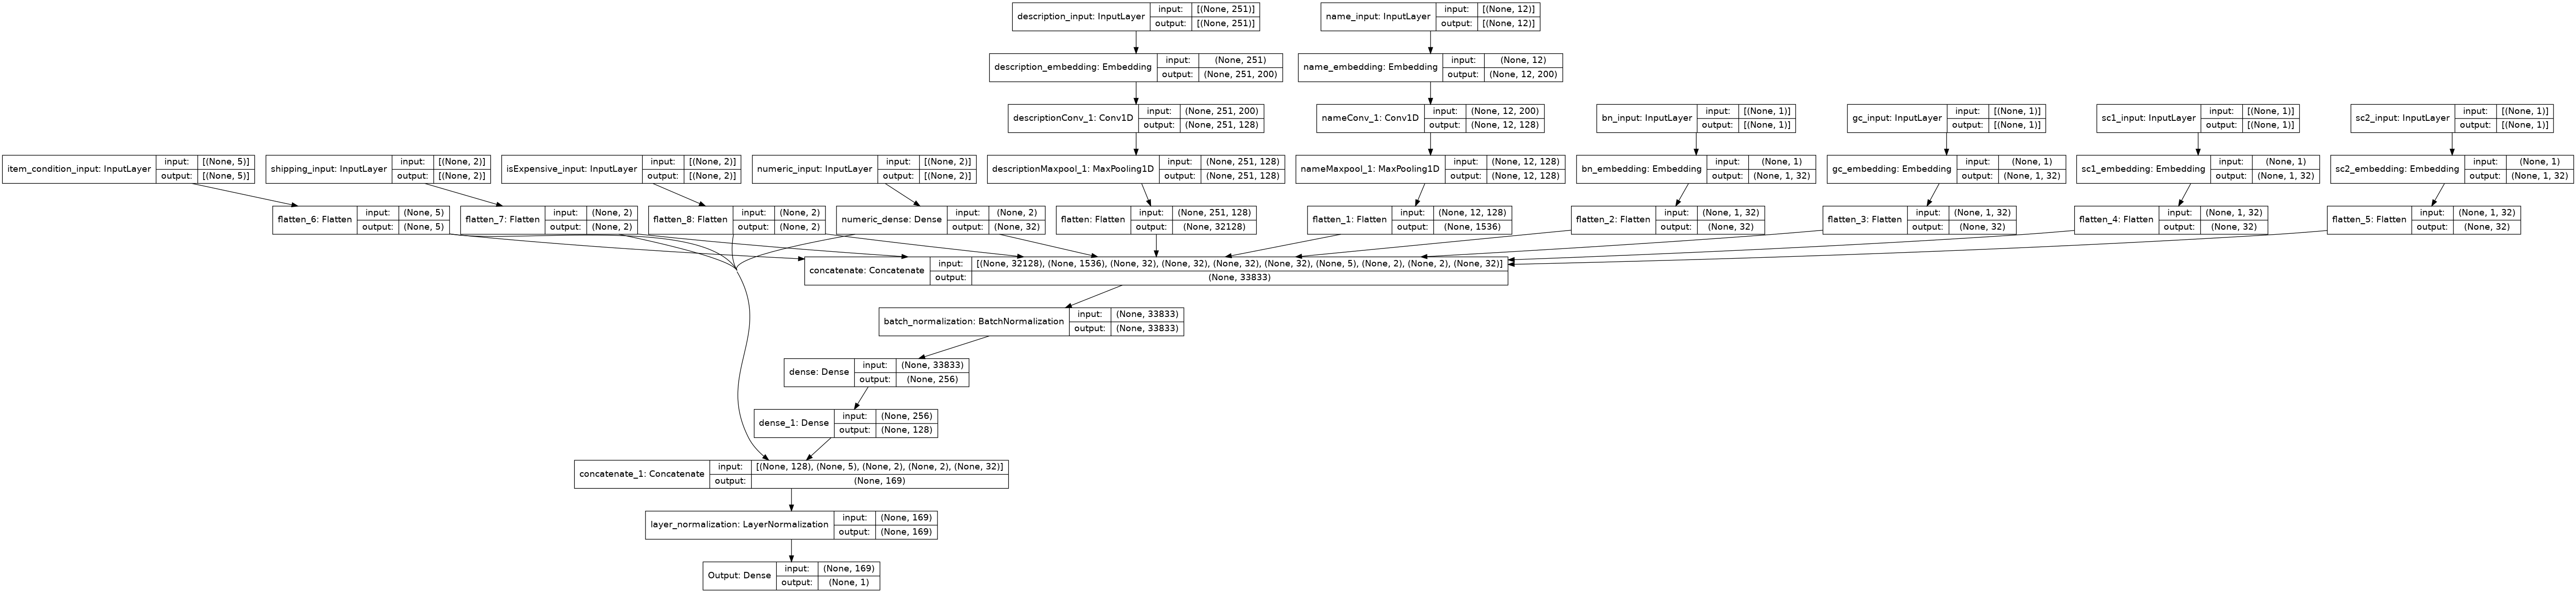

In [16]:
tf.keras.utils.plot_model(model=cnn_model, to_file='cnn_model_plot.png', show_shapes=True)

In [17]:
# # For more info on ModelCheckpoint, refer https://machinelearningmastery.com/check-point-deep-learning-models-keras/
# from tensorflow.keras.callbacks import ModelCheckpoint
# model_path = "/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/zzFINAL COMPLETED/FAST TEXT CNN/BEST_FT_CNN_MODEL.hdfs"
# checkpoint_best = ModelCheckpoint(filepath=model_path, monitor='val_loss',verbose=1, save_best_only=True, mode='min')

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
# https://stackoverflow.com/a/42963385/7697658
lrschedule_1 = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.70, mode='min')

In [19]:
# For more info on EarlyStoppingdelCheckpoint, refer https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_loss', verbose=1, patience=5)

In [20]:
checkpoint_path = "./cnn_checkpoints/cnn_ckpt.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_freq = 'epoch',
    save_best_only=True)

In [21]:
EPOCHS = 100
BATCH_SIZE = 256
adam = Adam(learning_rate=0.0003)
cnn_model.compile(optimizer=adam, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

cnn_model_hist = cnn_model.fit(x=X_train_inputs, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, validation_data=(X_test_inputs, y_test), 
                            callbacks=[cp_callback, lrschedule_1, earlystop])

Epoch 1/100
4833/4833 [==============================] - 169s 34ms/step - loss: 1.3167 - root_mean_squared_error: 0.6166 - val_loss: 0.3880 - val_root_mean_squared_error: 0.5371

Epoch 00001: val_loss improved from inf to 0.38803, saving model to ./cnn_checkpoints/cnn_ckpt.ckpt
Epoch 2/100
4833/4833 [==============================] - 164s 34ms/step - loss: 0.3356 - root_mean_squared_error: 0.5041 - val_loss: 0.3073 - val_root_mean_squared_error: 0.5071

Epoch 00002: val_loss improved from 0.38803 to 0.30731, saving model to ./cnn_checkpoints/cnn_ckpt.ckpt
Epoch 3/100
4833/4833 [==============================] - 165s 34ms/step - loss: 0.2895 - root_mean_squared_error: 0.4933 - val_loss: 0.2828 - val_root_mean_squared_error: 0.4959

Epoch 00003: val_loss improved from 0.30731 to 0.28278, saving model to ./cnn_checkpoints/cnn_ckpt.ckpt
Epoch 4/100
4833/4833 [==============================] - 165s 34ms/step - loss: 0.2745 - root_mean_squared_error: 0.4887 - val_loss: 0.2783 - val_root_mean

In [22]:
# Glove CNN = 0.21801/0.4551; Embeddings Trainable=True

### **Test Pipeline**

In [23]:
from sklearn.preprocessing import StandardScaler
def get_len_feature(col_series, scaler_text_len=None):
    """
    Description:
    This funciton will calculate the word count of the text and standardize it.

    Input: Series, fitted scaler[optional; used during inference]
    Output: standardized text length for each product and object of the fitted scaler
    """
    text_len = col_series.apply(lambda x: len(x.split()))
    if scaler_text_len==None:
        scaler_text_len = StandardScaler()
        scaler_text_len.fit(text_len.values.reshape(-1, 1))
    text_len = scaler_text_len.transform(text_len.values.reshape(-1, 1))
    return text_len, scaler_text_len

In [24]:
# with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/zzFINAL COMPLETED/BERT CNN/scalers.pkl', 'rb') as f:
#     scaler_name_len, scaler_desc_len = pickle.load(f)


In [25]:
# test = pd.read_csv('test_stg2.tsv', sep='\t')
# X_te, _, _ = feature_pipeline(test, scaler_name_len, scaler_desc_len)

In [26]:
####################### Text data ######################
_, _, _, _, desc_text_test_padded = text_embeddings(X_train['item_description'].apply(str), X_test['item_description'].apply(str))
_, _, _, _, name_text_test_padded = text_embeddings(X_train['name'].apply(str), X_test['name'].apply(str))
########################################################


################### Categorical data ###################
_, _, bn_encoded_test = categorical_embeddings(X_train['brand_name'], X_test['brand_name'])
_, _, gc_encoded_test = categorical_embeddings(X_train['general_cat'], X_test['general_cat'])
_, _, sc1_encoded_test = categorical_embeddings(X_train['subcat_1'], X_test['subcat_1'])
_, _, sc2_encoded_test = categorical_embeddings(X_train['subcat_2'], X_test['subcat_2'])
#########################################################


################### Numeric data ###################
numeric_test_input = pd.concat((X_test['scaler_desc_len'], X_test['scaler_name_len']), axis=1).to_numpy()


X_te = [desc_text_test_padded, name_text_test_padded, bn_encoded_test, gc_encoded_test, sc1_encoded_test, sc2_encoded_test, tf.one_hot(X_test['item_condition_id'], 5),\
                tf.one_hot(X_test['shipping'], 2), tf.one_hot(X_test['is_expensive'], 2), numeric_test_input]

In [27]:
def evaluate_dl_model(model, X_data, y_act):
    y_pred = model.predict(X_data)

    act_prices = np.exp(y_act)
    pred_prices = np.exp(y_pred)

    rms = np.sqrt(mean_squared_log_error(act_prices, pred_prices))
    return rms

In [28]:
evaluate_dl_model(cnn_model, X_te, y_test)

0.4386312316622073

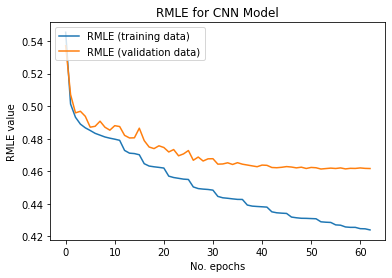

In [29]:
plt.plot(cnn_model_hist.history['root_mean_squared_error'], label='RMLE (training data)')
plt.plot(cnn_model_hist.history['val_root_mean_squared_error'], label='RMLE (validation data)')
plt.title('RMLE for CNN Model')
plt.ylabel('RMLE value')
plt.xlabel('No. epochs')
plt.legend(loc="upper left")
plt.show()

In [30]:
# def create_submission_output_file(model, X_data, bs=64):
#     submission_prices = model.predict(X_data, batch_size=bs)
#     submission_prices = np.exp(submission_prices)
#     submission_prices = np.squeeze(submission_prices, axis=1)
#     my_submission = pd.DataFrame({'test_id': test['test_id'], 'price': submission_prices})
#     my_submission.to_csv("/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/Submission/submission_ft_cnn.csv", index=False)

In [31]:
# model_path = "/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/zzFINAL COMPLETED/FAST TEXT CNN/BEST_FT_CNN_MODEL.hdfs"
# model_best = tf.keras.models.load_model(model_path)

In [32]:
# create_submission_output_file(model_best, X_test_submission)